In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import random
import time
import os
import sys
import mat73
from torchsummary import summary

In [ ]:

PROJECT_ROOT = r'c:\Users\WangCo\Documents\ProgramData\Python\radar_interference_suppression'

if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)


print("Current working directory:", os.getcwd())
print("Project root directory:", PROJECT_ROOT)
print("Python path:", sys.path)


os.chdir(PROJECT_ROOT)
print("\nNew working directory:", os.getcwd())

Current working directory: c:\Users\WangCo\Documents\ProgramData\Python\radar_interference_suppression
Project root directory: c:\Users\WangCo\Documents\ProgramData\Python\radar_interference_suppression
Python path: ['c:\\Users\\WangCo\\AppData\\Local\\Programs\\Python\\Python311\\python311.zip', 'c:\\Users\\WangCo\\AppData\\Local\\Programs\\Python\\Python311\\DLLs', 'c:\\Users\\WangCo\\AppData\\Local\\Programs\\Python\\Python311\\Lib', 'c:\\Users\\WangCo\\AppData\\Local\\Programs\\Python\\Python311', '', 'C:\\Users\\WangCo\\AppData\\Roaming\\Python\\Python311\\site-packages', 'C:\\Users\\WangCo\\AppData\\Roaming\\Python\\Python311\\site-packages\\win32', 'C:\\Users\\WangCo\\AppData\\Roaming\\Python\\Python311\\site-packages\\win32\\lib', 'C:\\Users\\WangCo\\AppData\\Roaming\\Python\\Python311\\site-packages\\Pythonwin', 'c:\\Users\\WangCo\\AppData\\Local\\Programs\\Python\\Python311\\Lib\\site-packages', 'c:\\Users\\WangCo\\Documents\\ProgramData\\Python\\radar_interference_suppressio

In [4]:
import importlib
# import src
from src.utils import analysis
from src.utils import training_validation
from src.utils import evaluation
from src.data import data_utils
from src.utils import visualization
from src.data.dataset import RadarDataset
from src.models import dualpath_autoencoder

In [ ]:

importlib.reload(data_utils)
importlib.reload(visualization)
importlib.reload(analysis)
importlib.reload(training_validation)
importlib.reload(evaluation)
importlib.reload(dualpath_autoencoder)

print("Modules reloaded successfully!")
# # # Reload the modules to get the latest changes

Loading scenario data...

Scenario 1 loaded:
Shape: (256, 128, 60)
Number of frames: 60
[{'scenario_id': 1, 'num_frames': 60, 'shape': (256, 128, 60)}]
Input shapes - radar_cube: (256, 128, 60), clean_data: (256, 128, 60)
Data types - radar_cube: complex128, clean_data: complex128

Data statistics:
Radar cube - Mean amplitude: 0.107
Radar cube - Max amplitude: 0.206
Clean data - Mean amplitude: 0.104
Clean data - Max amplitude: 0.156
Analyzing original data...

Analyzing Range-Doppler Processing...

Peak Analysis:
Doppler peaks:
Velocity: -48.89 m/s
Velocity: -40.00 m/s

Range peaks:
Range: 51.50 m
Range: 56.00 m


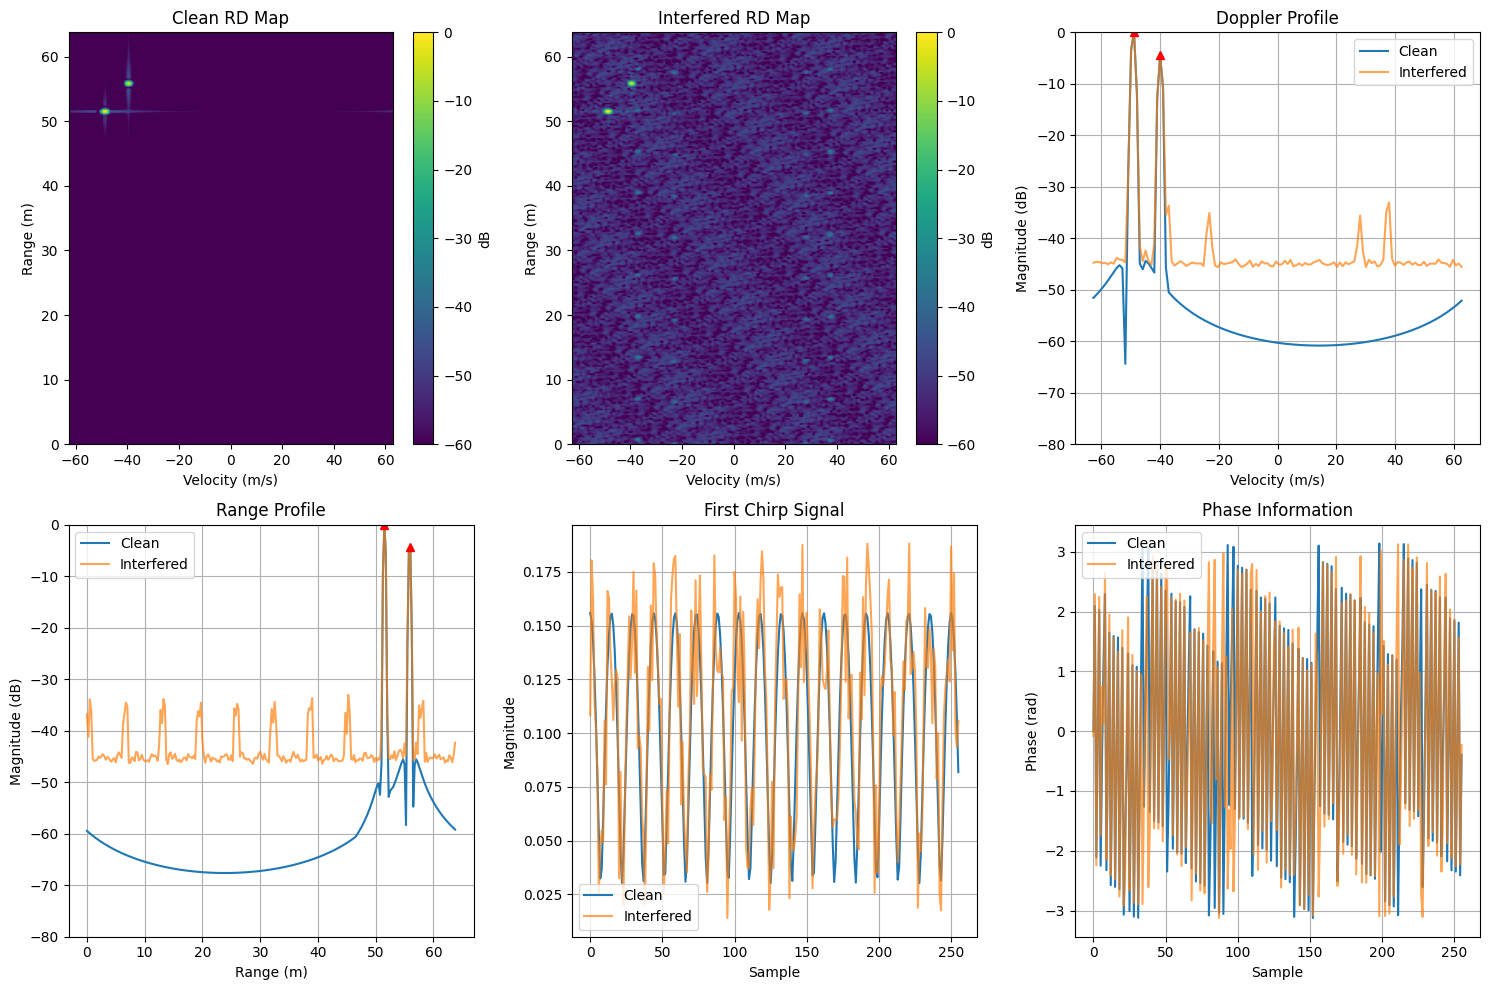

In [6]:
scenario_files = [
    os.path.join(PROJECT_ROOT, 'datasets', 'raw', 'train_dataset_2t1_60f.mat')  
]

    # Load and analyze all scenarios
print("Loading scenario data...")
radar_cube, clean_data, scenario_info = data_utils.load_multiple_scenarios(scenario_files)

# DEBUG INFO
print(f"Input shapes - radar_cube: {radar_cube.shape}, clean_data: {clean_data.shape}")
print(f"Data types - radar_cube: {radar_cube.dtype}, clean_data: {clean_data.dtype}")

# Check data values
print("\nData statistics:")
print(f"Radar cube - Mean amplitude: {np.mean(np.abs(radar_cube)):.3f}")
print(f"Radar cube - Max amplitude: {np.max(np.abs(radar_cube)):.3f}")
print(f"Clean data - Mean amplitude: {np.mean(np.abs(clean_data)):.3f}")
print(f"Clean data - Max amplitude: {np.max(np.abs(clean_data)):.3f}")

# Analyze original data
print("Analyzing original data...")
analysis.analyze_rd_processing(radar_cube, clean_data)

In [7]:
# Data preparation
full_dataset = RadarDataset(radar_cube, clean_data)
val_size = int(len(full_dataset) * 0.2)
print(f"size of validation: {val_size}")
train_size = len(full_dataset) - val_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

batch_size = 4
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

complex_to_real() triggered:
Real part range: [-0.206, 0.206]
Imag part range: [-0.205, 0.205]
complex_to_real() triggered:
Real part range: [-0.156, 0.156]
Imag part range: [-0.156, 0.156]
Dataset shapes after processing:
Interference data shape: (2, 256, 128, 60)
Clean data shape: (2, 256, 128, 60)
Number of frames: 60
size of validation: 12


In [8]:
# Load 2 models
model_paths = {
    'original': './outputs/models/best_model_unpruned.pth',
    'optimized': './outputs/models/best_model_pruned.pth'
}

In [ ]:

results = {}

scenario_radar = radar_cube[:, :, 0]
scenario_clean = clean_data[:, :, 0]


for model_name, model_path in model_paths.items():
    print(f"\nEvaluating {model_name} model...")
    

    model = dualpath_autoencoder.DualPathRadarAutoencoder(num_samples=256, num_chirps=128)
    

    checkpoint = torch.load(model_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()

    metrics = evaluation.evaluate_reconstruction(
        model,
        radar_cube,
        clean_data,  
    )
    
    results[model_name] = metrics


print("\nModel Comparison Results:")
analysis.compare_metrics(results['original'], results['optimized'])